In [77]:
# Imports
%matplotlib notebook

import sys
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

In [78]:
nb_of_samples = 20
sequence_len = 10

X = np.zeros((nb_of_samples, sequence_len))
for row in range(nb_of_samples):
    X[row,:] = np.around(np.random.rand(sequence_len)).astype(int)

t = np.sum(X, axis=1)

In [79]:
def update_state(xk, sk, wx, wRec):
    return xk * wx + wRec * sk

def forward_states(X, wx, wRec):
    S = np.zeros((X.shape[0], X.shape[1] + 1))
    
    for k in range(0, X.shape[1]):
        S[:, k + 1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S

def loss(y, t):
    return np.mean((t-y)**2)

In [80]:
def output_gradient(y, t):
    return 2. * (y - t)

In [81]:
def backward_gradient(X, S, grad_out, wRec):
    grad_over_time = np.zeros((X.shape[0], X.shape[1] + 1))
    grad_over_time[:, -1] = grad_out
    
    wx_grad = 0
    wRec_grad = 0
    cnt = 0
    for k in range(X.shape[1], 0, -1):
        grad_over_time[:, k - 1] = grad_over_time[:, k] * wRec
        wx_grad += np.sum(np.mean(grad_over_time[:, k] * X[:, k-1], axis=0))
        wRec_grad += np.sum(np.mean(grad_over_time[:, k] * S[:,k-1], axis=0))
        
    return (wx_grad, wRec_grad), grad_over_time 

In [82]:
# Set the weight parameters used during gradient checking
params = [1.2, 1.2]  # [wx, wRec]
# Set the small change to compute the numerical gradient
eps = 1e-7
# Compute the backprop gradients
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:,-1], t)
backprop_grads, grad_over_time = backward_gradient(
    X, S, grad_out, params[1])
# Compute the numerical gradient for each parameter in the layer
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to 
    #  the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Numerical gradient of {grad_num:.6f} is not close to '
            f'the backpropagation gradient of {grad_backprop:.6f}!'))
print('No gradient errors found')

No gradient errors found


In [83]:
points = [(2,1,'r'), (1,2,'b'), (1.2,0.997,'m'), (1,0,'c'), 
          (1,0.5,'g'), (1,-0.5,'y')]

In [84]:
def get_loss_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws, loss_func):
    w1 = np.linspace(w1_low, w1_high, num = nb_of_ws)
    w2 = np.linspace(w2_low, w2_high, num = nb_of_ws)
    
    ws1, ws2 = np.meshgrid(w1, w2)
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))
    
    for i in range (nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i, j] = loss_func(ws1[i,j], ws2[i, j])
    return ws1, ws2, loss_ws

def plot_surface(ax, ws1, ws2, loss_ws):
    """Plot the loss in function of the weights."""
    surf = ax.contourf(
        ws1, ws2, loss_ws, levels=np.logspace(-0.2, 8, 30), 
        cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=12)
    ax.set_ylabel('$w_{rec}$', fontsize=12)
    return surf


def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

In [85]:
def get_loss_surface_figure(loss_func, points):
    """Plot the loss surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))   
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 100, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        -0.1, 2.1, -0.1, 2.1, 100, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(-0.1, 2.1)
    ax_2.set_ylim(-0.1, 2.1)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Loss surface', fontsize=15)
    return fig

def plot_gradient_over_time(points, get_grad_over_time):
    """Plot the gradients of the annotated points and how 
    they evolve over time."""
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(
            x, np.sum(grad_over_time, axis=0), c+'-', 
            label=f'({wx}, {wRec})', linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, 
                -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', 
               fontsize=20, rotation=0)
    plt.title(('Unstability of gradient in backward propagation.'
               '\n(backpropagate from left to right)'))
    # Set legend
    leg = plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5), 
        frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    fig.subplots_adjust(right=0.8)

In [86]:
def get_grad_over_time(wx, wRec):
    """Helper func to only get the gradient over time 
    from wx and wRec."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time

<IPython.core.display.Javascript object>


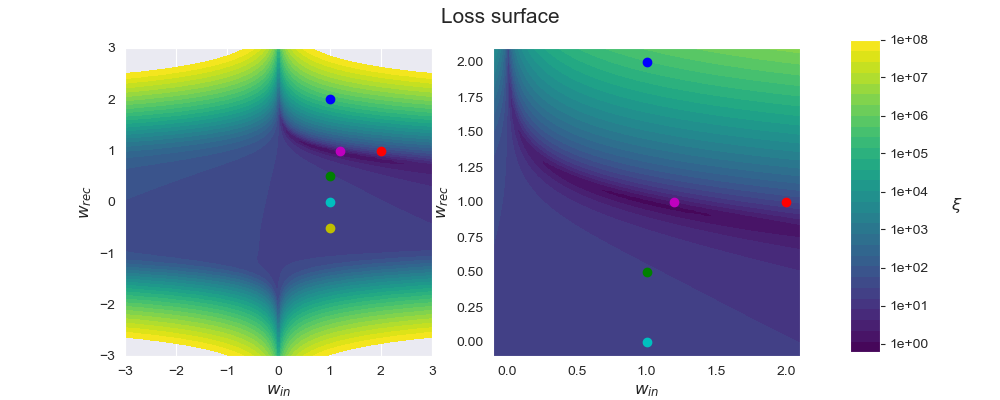

<IPython.core.display.Javascript object>


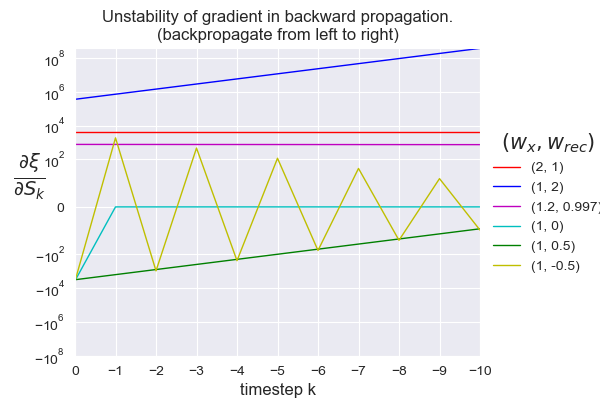

In [87]:
fig = get_loss_surface_figure(
    lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t), points)

# Get the plots of the gradients changing by backpropagating.
plot_gradient_over_time(points, get_grad_over_time)
# Show figures
plt.show()

In [88]:
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:, -1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)
    
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] = W_delta[i] * eta_p
        else:
            W_delta[i] = W_delta[i] * eta_n
            
    return W_delta, W_sign

<IPython.core.display.Javascript object>


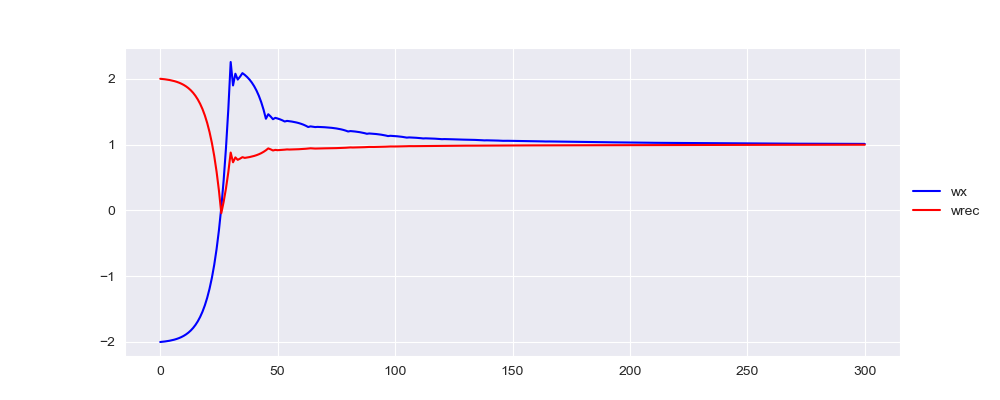

In [129]:
eta_p = 1.2
eta_n = 0.5

W = [-2, 2]
W_delta = [0.003, 0.003]
W_sign = [-1, 1]

ls_of_ws = [(W[0], W[1])]
nb_of_iters = 300
for i in range(nb_of_iters):
    W_delta, W_sign = update_rprop(X, t, W, W_sign, W_delta, eta_p, eta_n)
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))
    
fig = plt.figure(figsize=(10,4))

ls1 = []
ls2 = []

for i in range(len(ls_of_ws)):
    ls1.append(ls_of_ws[i][0])
    ls2.append(ls_of_ws[i][1])
plt.plot(ls1, 'b-', label='wx')
plt.plot(ls2, 'r-', label='wrec')
leg = plt.legend(
loc='center left', bbox_to_anchor=(1, 0.5), 
frameon=False, numpoints=1)